In [1]:
!pip3 install --upgrade keras-nlp

In [2]:
import platform

import numpy as np
import matplotlib.pyplot as plt

import keras
import keras_nlp
import tensorflow as tf
import tensorflow_datasets as tfds

Using TensorFlow backend


In [3]:
# Sometimes, the learning with tensorflow-metal does not converge.
# @see
# - https://forums.developer.apple.com/forums/thread/736187
# - https://forums.developer.apple.com/forums/thread/701056
# - https://forums.developer.apple.com/forums/thread/742157
# Therefore, it might be best to execute learning without metal and execute learning again in the last tuning phase.
# if platform.processor() == "arm":
#     print("This is running on M1/M2 mac.")
#     tf.config.set_visible_devices([], 'GPU')
# print(f"Tensorflow {tf.__version__} is running. This notebook was written with Tensorflow 2.15.0.")
# print(f"Keras {keras.__version__} is running. This notebook was written with Keras 2.15.0.") 

***

In [4]:
def plot(history, title=None):
    """
    Display the plot that indicates the loss and accuracy.
    :param history: history object from the tensorflow fit function.
    :param title: title text.
    """
    flg, axes = plt.subplots(1, 2, tight_layout=True)
    if title is not None:
        flg.suptitle(t=title, fontsize=14)
    for i, key in enumerate(["loss", "accuracy"]):
        value = history.history[key]
        val_loss = history.history[f"val_{key}"]
        epochs = range(1, len(value) + 1)
        axes[i].plot(epochs, value, label=f"Training {key}")
        axes[i].plot(epochs, val_loss, label=f"Validation {key}")
        axes[i].set_title(f"Training and validation {key}")
        axes[i].set_xlabel("epochs")
        axes[i].set_ylabel(key)
        axes[i].legend()
    plt.show()

    print(
        np.min(history.history["val_loss"]),
        "The best number of epocs for the validation loss is",
        np.argmin(history.history["val_loss"]) + 1,
    )
    print(
        np.max(history.history["val_accuracy"]),
        "The best number of epocs for the validation accuracy is",
        np.argmax(history.history["val_accuracy"]) + 1,
    )

def load_ag_news_subset(batch_size, shuffle=False):
    """
    Load ag_news_subset dataset.
    :param batch_size: the number of batch size.
    :param shuffle: if True, it is shuffled.
    :return: a dataset object.
    """
    BUFFER_SIZE = 10000
    dataset, info = tfds.load(
        'ag_news_subset',
        with_info=True,
        as_supervised=False
    )
    train_dataset, test_dataset = dataset['train'], dataset['test']

    if shuffle:
        # If shuffle is hopefully used,
        # the reshuffle_each_iteration parameter must be False.
        # Or the partial training dataset and the validation set are contaminated.
        train_dataset = train_dataset.shuffle(
            buffer_size=BUFFER_SIZE,
            reshuffle_each_iteration=False
        )
        test_dataset = test_dataset.shuffle(
            buffer_size=BUFFER_SIZE,
            reshuffle_each_iteration=False
        )

    partial_train_dataset = train_dataset.take(len(train_dataset) // 10 * 8)
    val_dataset = train_dataset.skip(len(train_dataset) // 10 * 8)

    print("The number of training set is", len(train_dataset))
    print("The number of partial training set is", len(partial_train_dataset))
    print("The number of validation set is", len(val_dataset))

    # In advance, batch and prefetch are called. Or, they are needed for each use.
    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    partial_train_dataset = partial_train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, partial_train_dataset, val_dataset, test_dataset

def tuplize(x):
    """
    Transform a row from the dataset to learn.
    :param x: a single row of the dataset.
    :return: a tuple of the feature and the target.
    """
    return (
        x['title'] + ' ' + x['description'],# x: feature
        x['label']# y: target
    )

def build_text_vectorization_layer(
        dataset,
        max_tokens=25000,
        output_mode='int',
        sequence_length=50):
    """
    Build a TextVectorization layer for preprocessing of text/token.
    :param dataset: the tokenized text data.
    :param max_tokens: the number of token.
    :param output_mode: for the param of TextVectorization. multi_hot/int is expected.
    :return: a TextVectorization layer.
    """
    vectorization_layer = keras.layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode=output_mode,
        output_sequence_length=sequence_length
    )
    vectorization_layer.adapt(dataset.map(lambda x: x['description'] + ' ' + x['title']))
    # The test set should not be adapted.
    #vectorization_layer.adapt(test_dataset.map(lambda x: x['description'] + ' ' + x['title']))
    return vectorization_layer

def build_model(
        vectorization_layer: keras.layers.TextVectorization,
        max_tokens=25000,
        embedding_dim=128,
        intermediate_dim=32,
        num_heads=4,
        sequence_length=50,
        name=None):
    if platform.system() == "Darwin" and platform.processor() == "arm":
        """
        Apple Silicon mac shows tht following warning.
        WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs,
        please use the legacy Keras optimizer instead,
        located at `tf.keras.optimizers.legacy.Adam`
        Therefore, keras.optimizers.legacy.Adam is used.
        """
        optimizer = keras.optimizers.legacy.Adam()
    else:
        optimizer = keras.optimizers.Adam()
    """
    Build a sequential model with the TextVectorization and Embedding.
    :param vectorization_layer: the layer object where sentence is converted to int.
    :param max_tokens: the number of token.
    :param embedding_dim: the number of dimension for embedding.
    :param intermediate_dim: the number of units.
    :param num_heads: the number of heads.
    :param sequence_length: the length of a sequence.
    :param name: the name of the model.
    :return: a sequential model.
    """
    inputs = keras.layers.Input(shape=(1,), dtype="string")
    x = vectorization_layer(inputs)
    x = keras_nlp.layers.TokenAndPositionEmbedding(
        vocabulary_size=max_tokens,
        sequence_length=sequence_length,
        embedding_dim=embedding_dim,
    )(x)
    x = keras_nlp.layers.TransformerEncoder(
        intermediate_dim=intermediate_dim,
        num_heads=num_heads
    )(inputs=x)
    x = keras.layers.GlobalMaxPooling1D()(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(4, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy'],
    )
    return model

2024-05-28 23:41:22.410159: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-05-28 23:41:22.410195: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-28 23:41:22.410200: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-28 23:41:22.410273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-28 23:41:22.410299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The number of training set is 120000
The number of partial training set is 96000
The number of validation set is 24000


2024-05-28 23:41:22.635656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
24/24 [==============================] - 80s 3s/step - loss: 1.5857 - accuracy: 0.4337 - val_loss: 0.5901 - val_accuracy: 0.8472
Epoch 2/20
24/24 [==============================] - 86s 4s/step - loss: 0.5080 - accuracy: 0.8277 - val_loss: 0.3337 - val_accuracy: 0.8969
Epoch 3/20
24/24 [==============================] - 90s 4s/step - loss: 0.2915 - accuracy: 0.9085 - val_loss: 0.2873 - val_accuracy: 0.9082
Epoch 4/20
24/24 [==============================] - 91s 4s/step - loss: 0.2052 - accuracy: 0.9383 - val_loss: 0.2710 - val_accuracy: 0.9127
Epoch 5/20
24/24 [==============================] - 97s 4s/step - loss: 0.1515 - accuracy: 0.9572 - val_loss: 0.2646 - val_accuracy: 0.9143
Epoch 6/20
24/24 [==============================] - 91s 4s/step - loss: 0.1142 - accuracy: 0.9709 - val_loss: 0.2624 - val_accuracy: 0.9147
Epoch 7/20
24/24 [==============================] - 90s 4s/step - loss: 0.0875 - accuracy: 0.9802 - val_loss: 0.2627 - val_accuracy: 0.9147
Epoch 8/20
24/24 [==

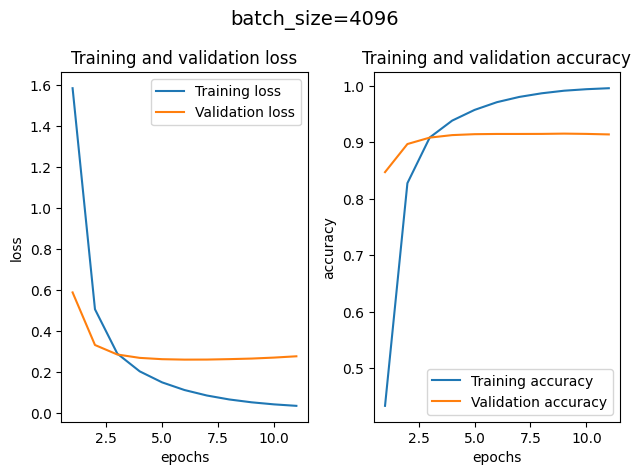

0.26244792342185974 The best number of epocs for the validation loss is 6
0.9152916669845581 The best number of epocs for the validation accuracy is 9
The number of training set is 120000
The number of partial training set is 96000
The number of validation set is 24000
Epoch 1/20
47/47 [==============================] - 76s 2s/step - loss: 1.3329 - accuracy: 0.5471 - val_loss: 0.3978 - val_accuracy: 0.8775
Epoch 2/20
47/47 [==============================] - 68s 1s/step - loss: 0.3640 - accuracy: 0.8805 - val_loss: 0.2930 - val_accuracy: 0.9049
Epoch 3/20
47/47 [==============================] - 71s 2s/step - loss: 0.2194 - accuracy: 0.9317 - val_loss: 0.2680 - val_accuracy: 0.9119
Epoch 4/20
47/47 [==============================] - 77s 2s/step - loss: 0.1463 - accuracy: 0.9579 - val_loss: 0.2612 - val_accuracy: 0.9136
Epoch 5/20
47/47 [==============================] - 71s 2s/step - loss: 0.1008 - accuracy: 0.9745 - val_loss: 0.2605 - val_accuracy: 0.9146
Epoch 6/20
47/47 [============

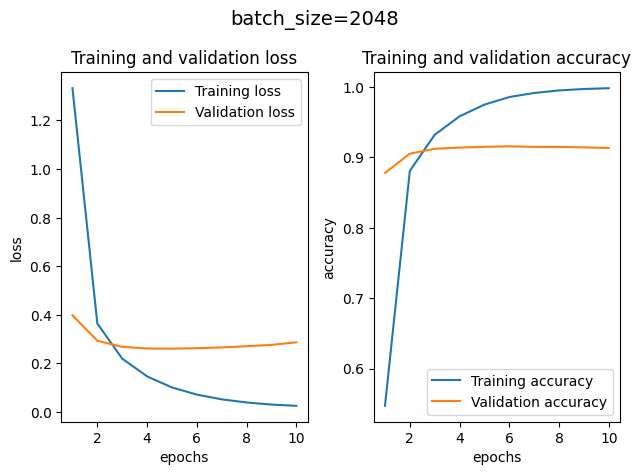

0.2604694664478302 The best number of epocs for the validation loss is 5
0.9153749942779541 The best number of epocs for the validation accuracy is 6
The number of training set is 120000
The number of partial training set is 96000
The number of validation set is 24000
Epoch 1/20
94/94 [==============================] - 74s 757ms/step - loss: 0.7609 - accuracy: 0.7141 - val_loss: 0.2920 - val_accuracy: 0.9062
Epoch 2/20
94/94 [==============================] - 67s 706ms/step - loss: 0.2411 - accuracy: 0.9214 - val_loss: 0.2566 - val_accuracy: 0.9160
Epoch 3/20
94/94 [==============================] - 70s 748ms/step - loss: 0.1440 - accuracy: 0.9562 - val_loss: 0.2618 - val_accuracy: 0.9142
Epoch 4/20
94/94 [==============================] - 71s 752ms/step - loss: 0.0885 - accuracy: 0.9759 - val_loss: 0.2621 - val_accuracy: 0.9139
Epoch 5/20
94/94 [==============================] - 70s 749ms/step - loss: 0.0561 - accuracy: 0.9866 - val_loss: 0.2814 - val_accuracy: 0.9152
Epoch 6/20
94/94

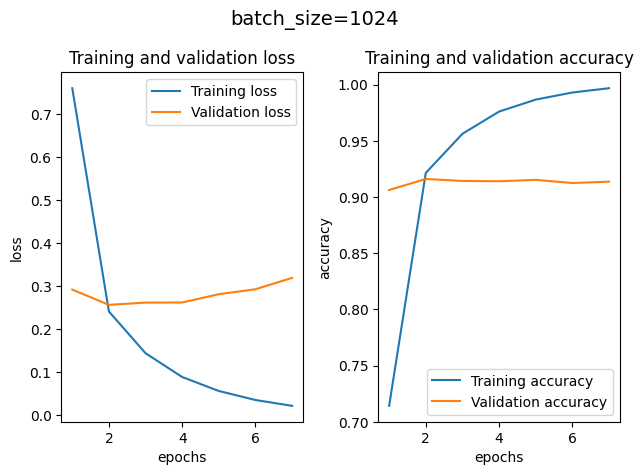

0.25659117102622986 The best number of epocs for the validation loss is 2
0.9159583449363708 The best number of epocs for the validation accuracy is 2
The number of training set is 120000
The number of partial training set is 96000
The number of validation set is 24000
Epoch 1/20
188/188 [==============================] - 85s 441ms/step - loss: 0.5903 - accuracy: 0.7835 - val_loss: 0.2833 - val_accuracy: 0.9080
Epoch 2/20
188/188 [==============================] - 74s 396ms/step - loss: 0.2114 - accuracy: 0.9307 - val_loss: 0.2639 - val_accuracy: 0.9096
Epoch 3/20
188/188 [==============================] - 78s 416ms/step - loss: 0.1210 - accuracy: 0.9626 - val_loss: 0.2686 - val_accuracy: 0.9122
Epoch 4/20
188/188 [==============================] - 75s 397ms/step - loss: 0.0685 - accuracy: 0.9806 - val_loss: 0.2784 - val_accuracy: 0.9154
Epoch 5/20
188/188 [==============================] - 78s 413ms/step - loss: 0.0411 - accuracy: 0.9892 - val_loss: 0.3100 - val_accuracy: 0.9136
Epoch

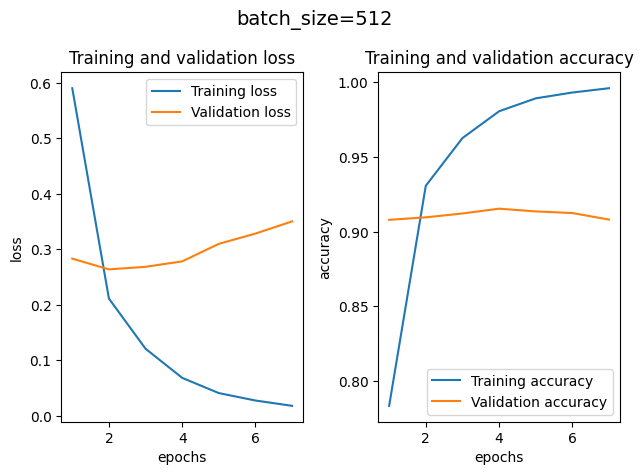

0.2639278471469879 The best number of epocs for the validation loss is 2
0.9154166579246521 The best number of epocs for the validation accuracy is 4
The number of training set is 120000
The number of partial training set is 96000
The number of validation set is 24000
Epoch 1/20
375/375 [==============================] - 87s 229ms/step - loss: 0.5099 - accuracy: 0.8174 - val_loss: 0.2581 - val_accuracy: 0.9139
Epoch 2/20
375/375 [==============================] - 75s 200ms/step - loss: 0.1905 - accuracy: 0.9367 - val_loss: 0.2446 - val_accuracy: 0.9161
Epoch 3/20
375/375 [==============================] - 79s 211ms/step - loss: 0.1013 - accuracy: 0.9683 - val_loss: 0.2635 - val_accuracy: 0.9139
Epoch 4/20
375/375 [==============================] - 75s 200ms/step - loss: 0.0503 - accuracy: 0.9861 - val_loss: 0.3107 - val_accuracy: 0.9106
Epoch 5/20
375/375 [==============================] - 79s 211ms/step - loss: 0.0287 - accuracy: 0.9928 - val_loss: 0.3583 - val_accuracy: 0.9094
Epoch 

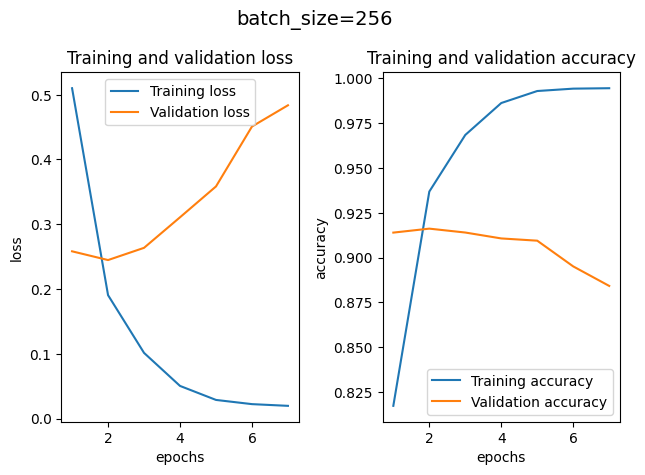

0.2446441501379013 The best number of epocs for the validation loss is 2
0.9160833358764648 The best number of epocs for the validation accuracy is 2


In [5]:
VOCAB_SIZE = 25000
BATCH_SIZE = 1024
NUM_HEADS = 4
INTERMEDIATE_DIM = 64
SEQ_LENGTH = 100

for batch_size in [4096, 2048, 1024, 512, 256]:
    train_dataset, partial_train_dataset, val_dataset, test_dataset = load_ag_news_subset(
        batch_size=batch_size
    )
    vectorization_layer = build_text_vectorization_layer(
        dataset=train_dataset,
        max_tokens=VOCAB_SIZE,
        output_mode='int',
        sequence_length=SEQ_LENGTH
    )
    model = build_model(
        vectorization_layer,
        max_tokens=VOCAB_SIZE,
        intermediate_dim=INTERMEDIATE_DIM,
        num_heads=NUM_HEADS,
        sequence_length=SEQ_LENGTH
    )
    history = model.fit(
        partial_train_dataset.map(tuplize, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False),
        validation_data=val_dataset.map(tuplize, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False),
        epochs=20,
        batch_size=batch_size,
        verbose=1,
        callbacks =[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        ]
    )
    plot(history=history, title=f"batch_size={batch_size}")